The task of recovering a high resolution (HR) image from its low resolution counterpart is commonly referred to as Single Image Super Resolution (SISR). 

The model implemented here is ESPCN ([Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158)) and we are going to use TensorFlow Lite to run inference on the trained model.

## Setup

We are going to need to do some color space transformation, so let's install OpenCV first.

In [6]:
!pip install opencv-python

Import dependencies.

In [7]:
import tensorflow as tf
import tarfile
import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Conv2D, Input, Lambda, Activation
from tensorflow.python.keras.models import Model
from os.path import exists, join, basename
from os import makedirs, remove, path
from six.moves import urllib

Set some parameters and download BSD300 dataset.

In [8]:
SCALE = 3
LR_SIZE = 100
# Make sure HR_SIZE is smaller than 300 since some images in the dataset have height/width < 300
HR_SIZE = LR_SIZE * SCALE

BATCH_SIZE = 100

def download_dataset(file, target_dir="dataset", extract=True):
    if not exists(join(target_dir, "BSDS300/images")):
        source_url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        target_dir = path.abspath(target_dir)
        tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)

download_dataset('BSDS300-images.tgz')

TRAIN_IMAGES = "dataset/BSDS300/images/train/*.jpg"  
TEST_IMAGES = "dataset/BSDS300/images/test/*.jpg"

ESPCN implements a simple network with 3 convolutional layers and 1 pixel shuffle layer on the Y channel (luminance) in the YCbCr color space. Cb and Cr channels are upsampled using bicubic method. We can prepare our training and test datasets as the following.

In [9]:
def extract_luminance(path):
    img = cv2.imread(path.numpy().decode('UTF8'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # Extract luminance
    img_y = img[:, :, 0:1]
    return img_y

def load_image(img_path):
    [hr_img,] = tf.py_function(extract_luminance, [img_path], [tf.float32])
    hr_img = tf.convert_to_tensor(hr_img)
    hr_img = tf.image.random_crop(hr_img, [HR_SIZE, HR_SIZE, 1])
    hr_img = tf.cast(hr_img, tf.float32)
    hr_img = hr_img / 255.
    lr_img = tf.image.resize(hr_img, [HR_SIZE//SCALE, HR_SIZE//SCALE], tf.image.ResizeMethod.BICUBIC)
    return lr_img, hr_img

training_dataset = tf.data.Dataset.list_files(TRAIN_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE) \
                   .shuffle(buffer_size = 200) 

test_dataset = tf.data.Dataset.list_files(TEST_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE)

## Build the model

In [10]:
# Helper function to wrap depth_to_space op (pixel shuffle) in a Lambda layer
def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

input = Input(shape=(LR_SIZE, LR_SIZE, 1))
x = Conv2D(64, [5, 5], padding='same', activation='relu')(input)
x = Conv2D(32, [3, 3], padding='same', activation='relu')(x)
x = Conv2D(SCALE**2, [3, 3], padding='same')(x)
x = Lambda(pixel_shuffle(scale=SCALE))(x)
x = Activation('tanh')(x)
model = Model(input, x, name="ESPCN")

logdir = "./logdir/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.MSE)

model.summary()

Model: "ESPCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 9)       2601      
_________________________________________________________________
lambda (Lambda)              (None, 300, 300, 1)       0         
_________________________________________________________________
activation (Activation)      (None, 300, 300, 1)       0         
Total params: 22,729
Trainable params: 22,729
Non-trainable params: 0
_________________________________________________________

## Train and export the model

In [11]:
model.fit(training_dataset,epochs= 700,validation_data=test_dataset,
                    callbacks = [tensorboard_callback],workers = 4)

model.save("export")

Epoch 1/700
2/2 [==============================] - 2s 827ms/step - loss: 0.2493 - val_loss: 0.2426
Epoch 2/700
2/2 [==============================] - 1s 718ms/step - loss: 0.2445 - val_loss: 0.2337
Epoch 3/700
2/2 [==============================] - 1s 719ms/step - loss: 0.2330 - val_loss: 0.2300
Epoch 4/700
2/2 [==============================] - 1s 729ms/step - loss: 0.2288 - val_loss: 0.2272
Epoch 5/700
2/2 [==============================] - 1s 726ms/step - loss: 0.2253 - val_loss: 0.2165
Epoch 6/700
2/2 [==============================] - 1s 735ms/step - loss: 0.2214 - val_loss: 0.2186
Epoch 7/700
2/2 [==============================] - 1s 701ms/step - loss: 0.2162 - val_loss: 0.2075
Epoch 8/700
2/2 [==============================] - 1s 743ms/step - loss: 0.2113 - val_loss: 0.2061
Epoch 9/700
2/2 [==============================] - 1s 724ms/step - loss: 0.2048 - val_loss: 0.2000
Epoch 10/700
2/2 [==============================] - 1s 701ms/step - loss: 0.1986 - val_loss: 0.1958
Epoch 11/

## Super resolve a test low resolution image using TensorFlow Lite.

In [12]:
def load_test_image(img_path):
    hr = cv2.imread(img_path)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2YCrCb)
    hr = tf.image.crop_to_bounding_box(hr, 0, 0, HR_SIZE, HR_SIZE)
    lr = tf.image.resize(hr, [HR_SIZE//SCALE, HR_SIZE//SCALE])
    lr = tf.cast(lr, tf.uint8)
    return lr, hr

def super_resolve(original_img_path):
    # lr - low resolution image
    # hr - high resolution image (cropped from original)
    # sr - super resolved image from lr
    lr, hr = load_test_image(original_img_path)
    lr_ycrcb = lr.numpy().copy()    
    lr = cv2.cvtColor(lr.numpy(), cv2.COLOR_YCrCb2RGB)
    hr = cv2.cvtColor(hr.numpy(), cv2.COLOR_YCrCb2RGB)   
    lr_ycrcb = tf.cast(lr_ycrcb, tf.float32)
    lr_y = lr_ycrcb[:, :, 0:1] / 255.
    lr_cr = lr_ycrcb[:, :, 1:2]
    lr_cb = lr_ycrcb[:, :, 2:3]
    lr_y = tf.expand_dims(lr_y, axis=0)
    
    # Use TFLite to super resolve luminance
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], lr_y)
    interpreter.invoke()
    sr_y = interpreter.get_tensor(output_details[0]['index'])
    open("ESPCN.tflite", 'wb').write(tflite_model)
    
    # Transform super resolved image back into RGB color space
    sr_y = sr_y * 255
    sr_cr = tf.image.resize(lr_cr, [HR_SIZE, HR_SIZE], tf.image.ResizeMethod.BICUBIC)
    sr_cb = tf.image.resize(lr_cb, [HR_SIZE, HR_SIZE], tf.image.ResizeMethod.BICUBIC)
    sr = tf.concat([sr_y[0], sr_cr, sr_cb], axis=2)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    sr = cv2.cvtColor(sr.numpy(), cv2.COLOR_YCrCb2RGB)
    return lr, sr, hr

# test_img_path = "dataset/BSDS300/images/test/170057.jpg"
test_img_path = "dataset/BSDS300/images/test/302008.jpg"
lr, sr, hr = super_resolve(test_img_path)

## Visualize the result

PSNR ([Peak Signal-to-Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)) is a commonly used metric to measure the image recovery quality.

PSNR of super resolved image: %f 29.192188


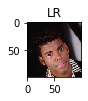

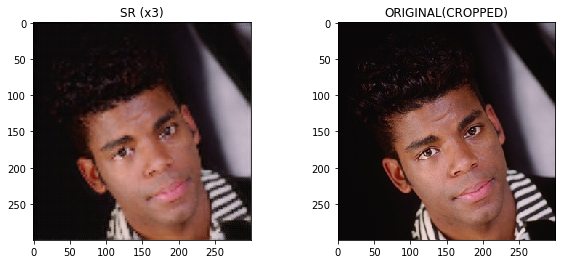

In [13]:
print("PSNR of super resolved image: %f", tf.image.psnr(sr, hr, 255).numpy())  

plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr);


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'SR (x{SCALE})')
plt.imshow(sr);


plt.subplot(1, 2, 2)   
plt.title('ORIGINAL(CROPPED)')
plt.imshow(hr);

## Check the PSNR for the entire test set

In [14]:
import os
test_directory = 'dataset/BSDS300/images/test/'
psnr_list = []
for file in os.listdir(test_directory):
    print(file)
    lr, sr, hr = super_resolve(os.path.join(test_directory + file))
    psnr = tf.image.psnr(sr, hr, 255).numpy()
    print('PSNR:', psnr)
    psnr_list.append(psnr)
    
print('Average PSNR for the test set: ', np.mean(psnr_list))

148026.jpg
PSNR: 18.863192
253027.jpg
PSNR: 19.138632
299086.jpg
PSNR: 31.346169
167062.jpg
PSNR: 23.770855
42012.jpg
PSNR: 28.549572
159008.jpg
PSNR: 25.572453
85048.jpg
PSNR: 22.7134
143090.jpg
PSNR: 29.45975
126007.jpg
PSNR: 26.959152
295087.jpg
PSNR: 25.035734
69020.jpg
PSNR: 24.869116
291000.jpg
PSNR: 19.046978
24077.jpg
PSNR: 20.815052
197017.jpg
PSNR: 25.253336
106024.jpg
PSNR: 26.554588
58060.jpg
PSNR: 18.227268
148089.jpg
PSNR: 20.603205
216081.jpg
PSNR: 22.814613
271035.jpg
PSNR: 23.809818
78004.jpg
PSNR: 22.375874
241004.jpg
PSNR: 26.488317
86000.jpg
PSNR: 22.015696
182053.jpg
PSNR: 21.25767
304074.jpg
PSNR: 23.435545
376043.jpg
PSNR: 22.338514
38092.jpg
PSNR: 23.28
62096.jpg
PSNR: 21.29691
19021.jpg
PSNR: 24.367304
102061.jpg
PSNR: 21.384264
55073.jpg
PSNR: 18.9711
156065.jpg
PSNR: 23.615484
210088.jpg
PSNR: 27.928673
41069.jpg
PSNR: 22.18991
119082.jpg
PSNR: 20.501284
223061.jpg
PSNR: 22.03998
300091.jpg
PSNR: 26.213572
296059.jpg
PSNR: 27.971807
101087.jpg
PSNR: 21.768602